In [49]:
import glob
import os
import random
import tarfile
import xml
from typing import Dict, List, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torch.nn.functional as F
import torchvision
import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset

## データの準備と確認

In [50]:
seed = 2913
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [51]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
voc_url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
voc_filename = "VOCtrainval_11-May-2012.tar"
if not os.path.exists(os.path.join(data_dir, voc_filename)):
    with open(os.path.join(data_dir, voc_filename), "wb") as f:
        res = requests.get(voc_url, stream=True)
        f.write(res.raw.read())
    tar_path = os.path.join(data_dir, voc_filename)
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(data_dir)

In [52]:
img_paths = sorted(
    glob.glob(os.path.join(data_dir, "VOCdevkit", "VOC2012", "JPEGImages", "*.jpg"))
)
print("size: ", len(img_paths))
img_paths[:3]

size:  17125


['./data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2007_000032.jpg',
 './data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg']

In [53]:
anno_paths = sorted(
    glob.glob(os.path.join(data_dir, "VOCdevkit", "VOC2012", "Annotations", "*.xml"))
)
print("size: ", len(anno_paths))
anno_paths[:3]

size:  17125


['./data/VOCdevkit/VOC2012/Annotations/2007_000027.xml',
 './data/VOCdevkit/VOC2012/Annotations/2007_000032.xml',
 './data/VOCdevkit/VOC2012/Annotations/2007_000033.xml']

### 可視化して確認

In [54]:
def extract_bboxes_labels(anno_file_path):
    anno = xml.etree.ElementTree.parse(anno_file_path)
    objects = anno.findall("object")
    bboxes = []
    labels = []
    for i, obj in enumerate(objects):
        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)

        bboxes.append([xmin, ymin, xmax, ymax])
        labels.append(obj.find("name").text)
    return bboxes, labels

In [55]:
def show_image(img, bboxes, labels, title=None, figsize=(10, 20)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)
    colors = ["red", "blue", "green", "yellow"]  # Define colors for each object

    for i, bbox in enumerate(bboxes):
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]
        ymax = bbox[3]

        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=colors[i % len(colors)],
        )
        ax.add_patch(rect)

    ax.legend(labels)
    if title:
        ax.set_title(title)
    plt.show()

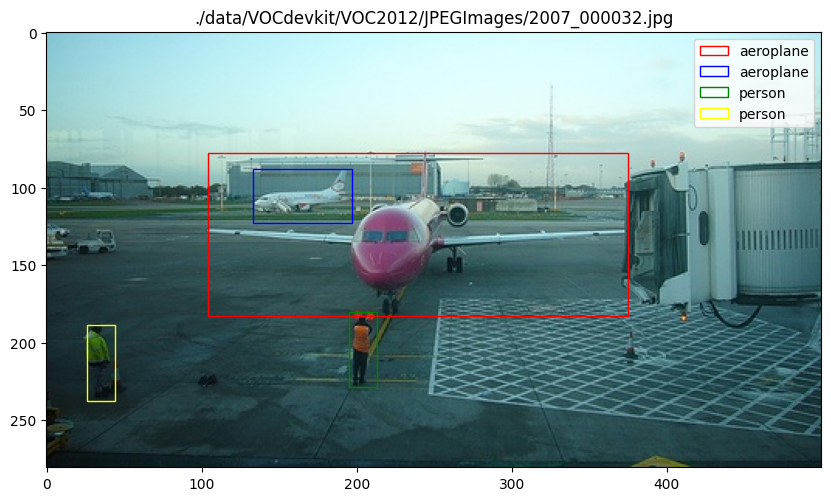

In [56]:
index = 1
img = Image.open(img_paths[index])
bboxes, labels = extract_bboxes_labels(anno_paths[index])
show_image(img, bboxes, labels, title=img_paths[index])

### どんなクラスがあるのかを確認

In [57]:
classes = []
for anno_path in anno_paths:
    anno = xml.etree.ElementTree.parse(anno_path)
    for obj in anno.findall("object"):
        classes.append(obj.find("name").text)
classes = list(set(classes))
classes.sort()
print("size:", len(classes))
classes

size: 20


['aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [58]:
label_encoder = LabelEncoder()
label_encoder.fit(classes)
label_encoder.transform(["horse"])

array([12])

### Datasetの作成

入力は画像データで、出力はbounding boxの4点の座標とラベルとなる。書籍のtransformは非常に複雑なので、シンプルにする。

また、書籍はOpenCVを使用しているが、第1章で使用したPillowをそのまま使いたいので、Pillowを使用する。一部、書籍とは画像の処理が異なっているが、気にしないで進める。画像のリサイズなどを行うので、影響が出ないようにboundig boxは正規化しておく。

In [59]:
class DataTransform:
    def __init__(
        self,
        size: tuple[int, int],
        label_encoder,
        color_mean: tuple[float, float, float],
        color_std: tuple[float, float, float],
    ):
        self.size = size
        self.label_encoder = label_encoder
        self.color_mean = color_mean
        self.color_std = color_std
        self.img_transform = {
            "train": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(size),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(self.color_mean, self.color_std),
                ]
            ),
            "val": torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(size),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(self.color_mean, self.color_std),
                ]
            ),
        }

    def __call__(
        self,
        img: Image.Image,
        bboxes: list[list[int]],
        labels: list[str],
        phase: Literal["train", "val"] = "train",
    ):
        transformed_img = self.img_transform[phase](img)
        width, height = img.size
        for bbox in bboxes:
            bbox[0] = bbox[0] / width * self.size[0]
            bbox[1] = bbox[1] / height * self.size[1]
            bbox[2] = bbox[2] / width * self.size[0]
            bbox[3] = bbox[3] / height * self.size[1]
        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(self.label_encoder.transform(labels), dtype=torch.float32)
        return transformed_img, bboxes, labels

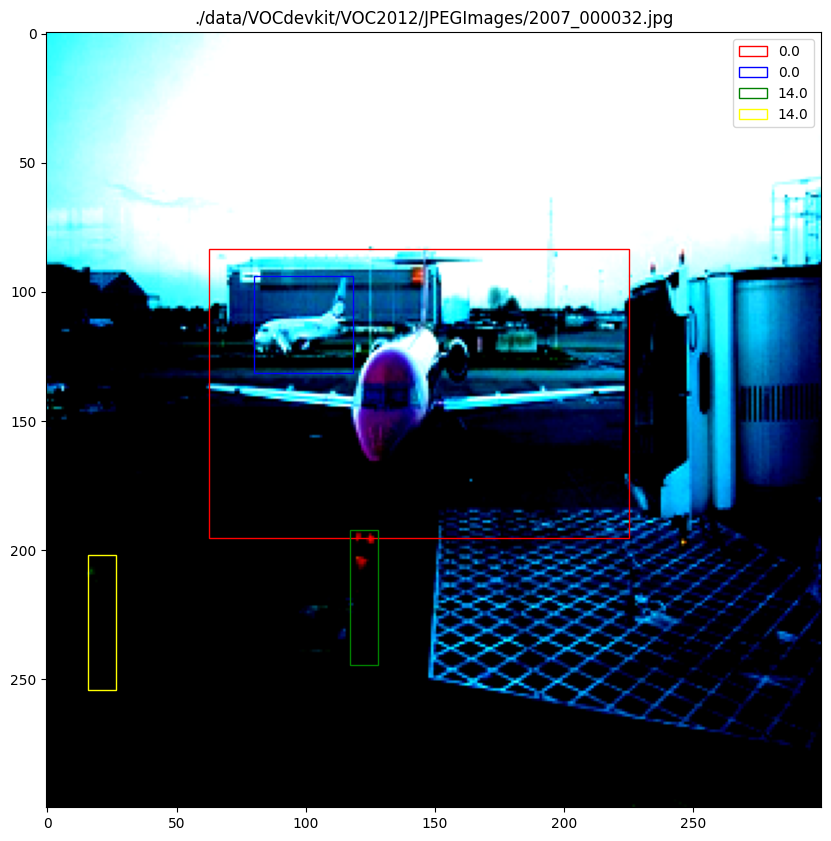

img shape: torch.Size([3, 300, 300])
boxes shape: torch.Size([4, 4])
labels shape: torch.Size([4])


In [60]:
data_transform = DataTransform(
    size=(300, 300),
    label_encoder=label_encoder,
    color_mean=(0.485, 0.456, 0.406),
    color_std=(0.229, 0.224, 0.225),
)
index = 1
img = Image.open(img_paths[index])
bboxes, labels = extract_bboxes_labels(anno_paths[index])
img, bboxes, labels = data_transform(img, bboxes, labels)
show_image(
    img.numpy().transpose(1, 2, 0),
    bboxes.numpy(),
    labels.numpy(),
    title=img_paths[index],
)
print("img shape:", img.shape)
print("boxes shape:", bboxes.shape)
print("labels shape:", labels.shape)

In [61]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        img_paths,
        anno_paths,
        size: tuple[int, int],
        transform,
        phase: str = "train",
    ):
        self.img_paths = img_paths
        self.anno_paths = anno_paths
        self.size = size
        self.transform = transform
        self.phase = phase
        if len(self.img_paths) != len(self.anno_paths):
            raise ValueError("The number of images and annotations must be the same.")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        img = Image.open(img_paths[index])
        bboxes, labels = extract_bboxes_labels(anno_paths[index])
        img, bboxes, labels = data_transform(img, bboxes, labels)
        gt = torch.hstack((bboxes, labels.unsqueeze(1)))
        return img, gt

In [62]:
train_img_paths, val_img_paths, train_anno_paths, val_anno_paths = train_test_split(
    img_paths, anno_paths, test_size=0.2, random_state=seed
)
train_dataset = VOCDataset(
    train_img_paths,
    train_anno_paths,
    size=(300, 300),
    transform=data_transform,
    phase="train",
)
val_dataset = VOCDataset(
    val_img_paths,
    val_anno_paths,
    size=(300, 300),
    transform=data_transform,
    phase="val",
)

In [63]:
img, gt = train_dataset[1]
print(img.shape)
print(gt.shape)

torch.Size([3, 300, 300])
torch.Size([4, 5])


問題ないか可視化して確認。

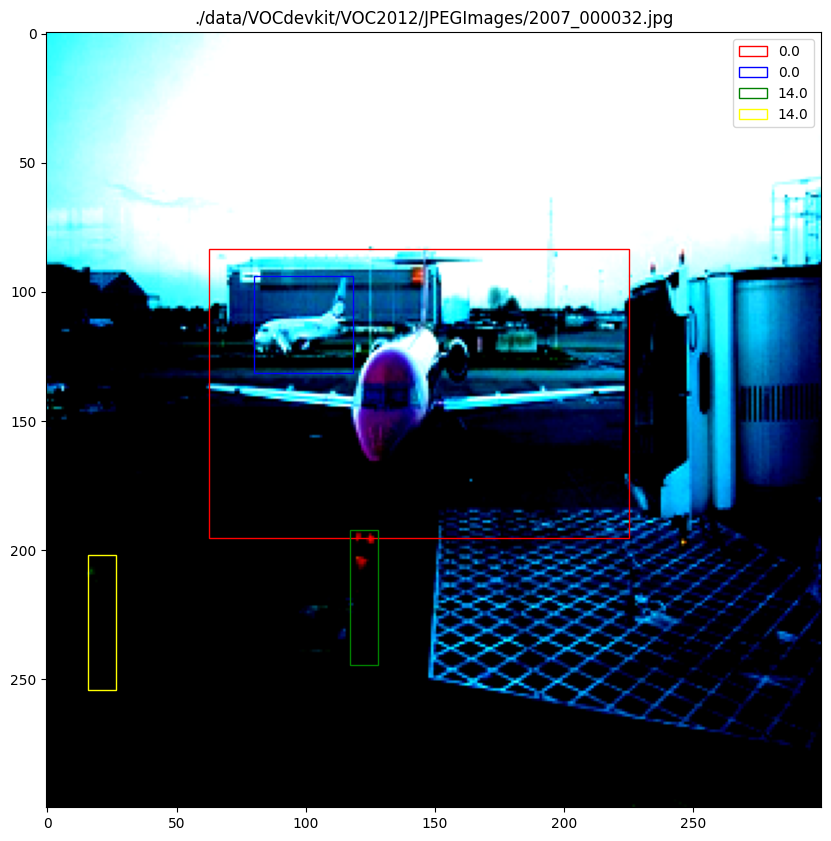

In [64]:
bboxes = np.array([_gt[:4].numpy() for _gt in gt])
labels = np.array([_gt[4].numpy() for _gt in gt])
show_image(img.numpy().transpose(1, 2, 0), bboxes, labels, title=img_paths[index])

## DataLoader

`collate_fn`が何のために必要なのかわからなかったので、まずは`collate_fn`無しだと何が起きるのかを確認する。
`collate_fn`無しだと、以下のようにエラーが生じる。

```python
RuntimeError: stack expects each tensor to be equal size, but got [1, 5] at entry 0 and [5, 5] at entry 1
```

デフォルトだと、各エポックでのサイズが同じでないといけないようだ。
そこで、`collate_fn`を指定する必要があるわけだが、特に工夫なくリストにして返しておけば良い。

In [65]:
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
# next(iter(train_dataloader))

In [66]:
def collate_fn(batch):
    imgs = torch.stack([_batch[0] for _batch in batch])
    targets = [torch.FloatTensor(_batch[1]) for _batch in batch]
    return imgs, targets

In [67]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)
_bactch = next(iter(train_dataloader))
_bactch[0].shape, _bactch[1][0].shape

(torch.Size([32, 3, 300, 300]), torch.Size([1, 5]))

## ネットワークの作成

書籍に書かれている通り、ネットワークモデルを実装する。

まずはVGGの実装をする。Convolution,ReLuを組み合わせつつ、適宜Max Poolingを入れる。

なお、Convolution部分では(300,300)のサイズは変わらず、Pooling部分で(150,150)などのようにサイズが変化する。
具体的な計算方法はドキュメントに記載されているので、ここで計算するのがいい。

- [Conv2d — PyTorch 2.1 documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#:~:text=output.%20Default%3A%20True-,Shape%3A,-Input%3A)
- [MaxPool2d — PyTorch 2.1 documentation](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#:~:text=the%20output%20shape-,Shape,-%3A)

色々とネットワークの実装をしなくてはいけないが、かなり複雑なのでめんどくさい。特に、途中で出力の次元などがわからなくなってくるなどの問題もあるので、ステップバイステップで確かめながら進めたいのだが、書籍のコード通り進めるとそうもいかない。

そこで、以下のような方針で作成することにした。

- VGGは分岐点の前後で分けて実装する(FormerVGG, LatterVGG)。こうすることで、純伝播の実装が楽になる。逆に、ここで分けておかないと、書籍の`forward`関数のように面倒な実装になってしまう。
- `torch.nn.ModuleList`ではなく、`torch.nn.Sequential`を使用する、あるいは`torch.nn.Module`を継承したクラスを作成する。書籍では、最後の`SDD`クラスでまとめて`forward`関数を実装している。しかしながら、このようにすると確認ができるのが最後になるので、ステップバイステップで進めることができない。各部をモジュールとしてしっかり完結させ、動作確認をできるようにする。
- MaxPoolingには、出力サイズからkernel_sizeなどを自動で計算してくれる[`torch.nn.AdaptiveAvgPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html)を使用する。

In [68]:
_batch_img = img.unsqueeze(0)
_batch_img.shape

torch.Size([1, 3, 300, 300])

In [69]:
class SerialConv2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, n_conv):
        super().__init__()
        self.conv = torch.nn.Sequential()
        for i in range(n_conv):
            self.conv.add_module(
                f"conv_{i+1}",
                torch.nn.Conv2d(
                    in_channels, out_channels, kernel_size=3, padding=1, stride=1
                ),
            )
            self.conv.add_module(f"relu_{i+1}", torch.nn.ReLU())
            in_channels = out_channels

    def forward(self, x):
        return self.conv(x)

In [70]:
_serial_conv2d1 = SerialConv2D(3, 64, 3)
_serlal_conv2d1_out = _serial_conv2d1(_batch_img)
print(_serlal_conv2d1_out.shape)
_serial_conv2d2 = SerialConv2D(64, 128, 3)
_serial_conv2d2_out = _serial_conv2d2(_serlal_conv2d1_out)
print(_serial_conv2d2_out.shape)

torch.Size([1, 64, 300, 300])
torch.Size([1, 128, 300, 300])


In [71]:
class FormerVGG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            SerialConv2D(3, 64, 2),
            torch.nn.AdaptiveAvgPool2d((150, 150)),
            SerialConv2D(64, 128, 2),
            torch.nn.AdaptiveAvgPool2d((75, 75)),
            SerialConv2D(128, 256, 3),
            torch.nn.AdaptiveAvgPool2d((38, 38)),
            SerialConv2D(256, 512, 3),
        )

    def forward(self, x):
        return self.layers(x)

In [72]:
_former_vgg = FormerVGG()
_former_vgg_out = _former_vgg(_batch_img)
print(_former_vgg_out.shape)

torch.Size([1, 512, 38, 38])


In [73]:
class LatterVGG(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((19, 19)),
            SerialConv2D(512, 512, 3),
            torch.nn.AdaptiveAvgPool2d((19, 19)),
            SerialConv2D(512, 1024, 2),
        )

    def forward(self, x):
        return self.layers(x)

In [74]:
_latter_vgg = LatterVGG()
_latter_vgg_out = _latter_vgg(_former_vgg_out)
print(_latter_vgg_out.shape)

torch.Size([1, 1024, 19, 19])


#### ExtraConv

Extras内で使用する畳み込み層。

Conv2Dの次元数を真ん中で小さくする理由は書籍で説明されていない。次元を一旦小さくして、有効な特徴量を取るため？

In [75]:
class ExtraConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, second_stride=2, second_padding=1):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels // 2, kernel_size=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(
                out_channels // 2,
                out_channels,
                kernel_size=3,
                stride=second_stride,
                padding=second_padding,
            ),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        return self.conv(x)

In [76]:
_extra1 = ExtraConv(1024, 512)
_extra1_out = _extra1(_latter_vgg_out)
print(_extra1_out.shape)

_extra2 = ExtraConv(512, 256)
_extra2_out = _extra2(_extra1_out)
print(_extra2_out.shape)

_extra3 = ExtraConv(256, 256, second_stride=1, second_padding=0)
_extra3_out = _extra3(_extra2_out)
print(_extra3_out.shape)

_extra4 = ExtraConv(256, 256, second_stride=1, second_padding=0)
_extra4_out = _extra4(_extra3_out)
print(_extra4_out.shape)

torch.Size([1, 512, 10, 10])
torch.Size([1, 256, 5, 5])
torch.Size([1, 256, 3, 3])
torch.Size([1, 256, 1, 1])


#### LocConv

loc内で使用する畳み込み層。

In [77]:
class LocConv(torch.nn.Module):
    def __init__(self, in_channels, n_bbox=4):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, n_bbox * 4, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

LocConvの出力は、最終的に`[1,8732,4]`というサイズで出力される。
その整形の際、`permute`(サイズの入れ替え)、`contiguous`(メモリ上で要素順に並べる、`view`の前に呼び出す必要があるとのこと)、`view`(サイズ調整)、などが後々使われる。
その挙動をここで確認しておく。

In [78]:
_loc_conv = LocConv(512)
_loc_conv_out = _loc_conv(_extra1_out)
print(_loc_conv_out.shape)
_loc_conv_out_premuted = _loc_conv_out.permute(0, 2, 3, 1).contiguous()
print(_loc_conv_out_premuted.shape)
_loc_conv_out_view = _loc_conv_out_premuted.view(_loc_conv_out_premuted.shape[0], -1)
print(_loc_conv_out_view.shape)

torch.Size([1, 16, 10, 10])
torch.Size([1, 10, 10, 16])
torch.Size([1, 1600])


In [79]:
_loc_conv_out_premuted

tensor([[[[-3.2121e-04,  1.4103e-03, -6.8245e-03,  ...,  6.1135e-03,
            8.9445e-03, -1.1072e-02],
          [ 3.6643e-04,  3.6797e-05, -3.2181e-03,  ...,  1.0808e-02,
            6.9301e-03, -1.5524e-02],
          [-7.1263e-04, -1.3691e-04, -2.9337e-03,  ...,  1.0569e-02,
            7.2040e-03, -1.5584e-02],
          ...,
          [-7.0530e-04, -1.4973e-04, -2.9346e-03,  ...,  1.0585e-02,
            7.2150e-03, -1.5573e-02],
          [ 4.7572e-05,  2.7779e-04, -2.8251e-03,  ...,  1.0526e-02,
            6.5615e-03, -1.4897e-02],
          [-2.9104e-03,  2.3237e-03,  3.1618e-03,  ...,  1.0343e-02,
            5.7618e-03, -1.5246e-02]],

         [[ 1.7789e-03,  4.7805e-03, -5.6804e-03,  ...,  9.0439e-03,
            1.1594e-02, -1.4143e-02],
          [-3.0984e-04,  8.2609e-04, -4.7674e-04,  ...,  1.2461e-02,
            1.2146e-02, -2.1379e-02],
          [-1.2640e-03,  8.5046e-04,  2.2705e-05,  ...,  1.2499e-02,
            1.1764e-02, -2.1162e-02],
          ...,
     

In [80]:
_loc_conv_out_view

tensor([[-0.0003,  0.0014, -0.0068,  ...,  0.0052,  0.0131, -0.0195]],
       grad_fn=<ViewBackward0>)

`ConfConv`は`LocConv`とほぼ同じなので、そのまま流用する。

In [81]:
class ConfConv(torch.nn.Module):
    def __init__(self, in_channels, n_bbox=4, n_classes=21):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels, n_bbox * n_classes, kernel_size=3, padding=1
        )

    def forward(self, x):
        return self.conv(x)

In [82]:
_conf_conv = ConfConv(512)
_conf_conv_out = _conf_conv(_extra1_out)
print(_conf_conv_out.shape)

torch.Size([1, 84, 10, 10])


`L2Norm`は一旦飛ばす(何のためにあるのか、どこを正規化するかを自分がよく掴めていないため)。

#### Detector

被りを除去する`Detector`クラスを作成する。`torch.autograd.Function`を継承したクラスは、`forward`と`backward`の両方を実装する必要があるが、今回の例ではモデルが推論モードの時にしかこのクラスは使用されないので、`forward`のみを実装すれば良いようだ。

するべきことは以下

- `decode`: 被りを除去する。具体的には、被りが閾値以上のboxがある場合、confが最大のもののみを残してやり、他は削除する。
  - 各DBOXの$(cx_d, cy_d, w_d, h_d)$に対して、SSDは`loc`($\Delta c_x,\Delta c_y, \Delta w, \Delta h$)を出力する(式は`decode`および書籍参照)。
- 

`torch.cat`あたりの挙動が不安なので、確かめておく。

In [83]:
a = torch.Tensor([[1, 2, 3], [4, 5, 6]])
b = torch.Tensor([[7, 8, 9], [10, 11, 12]])
print("a: ", a)
print("a.shape: ", a.shape)
print("b: ", b)
print("b.shape: ", b.shape)
print("a+b: ", a + b)

a:  tensor([[1., 2., 3.],
        [4., 5., 6.]])
a.shape:  torch.Size([2, 3])
b:  tensor([[ 7.,  8.,  9.],
        [10., 11., 12.]])
b.shape:  torch.Size([2, 3])
a+b:  tensor([[ 8., 10., 12.],
        [14., 16., 18.]])


スライスを使用して以下のように足し算した後のサイズを頭の中で計算しておくと、理解が早いのかもしれない。

例えば、`a[:,1]`のサイズは、`dim=0`はそのまま、`dim=1`は1となる。

In [84]:
print("a[:, 1]+b[:, 1]", a[:, 1] + b[:, 1])
print("shape: ", (a[:, 1] + b[:, 1]).shape)

a[:, 1]+b[:, 1] tensor([10., 16.])
shape:  torch.Size([2])


In [85]:
print("torch.cat((a, b), dim=1).shape: ", torch.cat((a, b), dim=1).shape)
print(
    "torch.cat((a[:,:1], b[:,:1]), dim=1).shape: ",
    torch.cat((a[:, :1], b[:, :1]), dim=1).shape,
)

torch.cat((a, b), dim=1).shape:  torch.Size([2, 6])
torch.cat((a[:,:1], b[:,:1]), dim=1).shape:  torch.Size([2, 2])


In [86]:
class Detector(torch.autograd.Function):
    def __init__(self):
        super().__init__()

    def forward(self, locs, confs, dboxes):
        n_batch = locs.shape[0]
        n_class = locs.shape[1]
        pred_classes = torch.argmax(confs, dim=2)

#### SSD

上記をもとに、`SSD`を実装。`input_size`などを書籍のように入力引数としてしまうと、非常に複雑になるので、`input_size`が(300,300)であることなどは既知としてネットワークを作成していく。引数を変えても、`VGG`などをうまく変えないと動作しないと思う。

書籍では、`phase`引数を渡して、学習時と推論時の挙動を変えているが、`model.train()`,`model.eval()`で挙動を変えられると直感的で美しい。モデルが学習モードか推論モードかは、`self.training`に保存されているので、これを利用する。

デフォルトボックスは初期化時に作成する。

- 書籍のforwardでは、バッチごとにループを回す形になっているが、loopを回さずとも計算できるはずで、その方が計算も早いとも思われる。for loopはできるだけ回さないようにして実装を行なった。
- non-maximum suppressionは[Pytorchに標準搭載](https://pytorch.org/vision/main/generated/torchvision.ops.nms.html)されているので、これを使うようにする。書籍とは入出力が異なるので注意。

In [87]:
class SSD(torch.nn.Module):
    def __init__(
        self,
        num_classes=21,
        input_size=300,
        default_boxes=None,
        bbox_aspect_num=[4, 6, 6, 6, 4, 4],
    ):
        super().__init__()
        self.num_classes = num_classes
        self.former_vgg = FormerVGG()
        self.latter_vgg = LatterVGG()
        self.extras = torch.nn.ModuleList(
            [
                ExtraConv(1024, 512),
                ExtraConv(512, 256),
                ExtraConv(256, 256, second_stride=1, second_padding=0),
                ExtraConv(256, 256, second_stride=1, second_padding=0),
            ]
        )

        self.source_out_channels = [
            list(self.former_vgg.parameters())[-1].shape[0],
            list(self.latter_vgg.parameters())[-1].shape[0],
        ] + [list(extra.parameters())[-1].shape[0] for extra in self.extras]

        self.locs = torch.nn.ModuleList(
            [
                LocConv(in_channels, n_bbox)
                for n_bbox, in_channels in zip(
                    bbox_aspect_num, self.source_out_channels
                )
            ]
        )

        self.confs = torch.nn.ModuleList(
            [
                ConfConv(in_channels, n_bbox, num_classes)
                for n_bbox, in_channels in zip(
                    bbox_aspect_num, self.source_out_channels
                )
            ]
        )

        self.softmax = torch.nn.Softmax(dim=-1)

        self.default_boxes = default_boxes

    def decode(self, loc, default_box):
        num_batch = loc.shape[0]
        default_box = default_box.unsqueeze(0).repeat(num_batch, 1, 1)
        boxes = torch.cat(
            (
                default_box[:, :, :2] + loc[:, :, :2] * 0.1 * default_box[:, :, 2:],
                default_box[:, :, 2:] * torch.exp(loc[:, :, 2:] * 0.2),
            ),
            dim=2,
        )
        boxes[:, :, :2] -= boxes[:, :, 2:] / 2
        boxes[:, :, 2:] += boxes[:, :, :2]
        return boxes

    def forward(self, x):
        num_batch = x.shape[0]

        sources = []
        # source1
        x = self.former_vgg(x)
        sources.append(x)
        # source2
        x = self.latter_vgg(x)
        sources.append(x)
        for extra in self.extras:
            x = extra(x)
            sources.append(x)

        # print(output_loc[0].shape)
        # torch.Size([1, 38, 38, 16])
        output_loc = [
            loc(source).permute(0, 2, 3, 1).contiguous()
            for source, loc in zip(sources, self.locs)
        ]

        # torch.Size([1, 34928])
        output_loc = torch.cat([o.view(o.size(0), -1) for o in output_loc], 1)

        # torch.Size([1, 8732, 4])
        output_loc = output_loc.view(num_batch, -1, 4)

        output_conf = [
            conf(source).permute(0, 2, 3, 1).contiguous()
            for source, conf in zip(sources, self.confs)
        ]
        output_conf = torch.cat([o.view(o.size(0), -1) for o in output_conf], 1)
        output_conf = output_conf.view(num_batch, -1, self.num_classes)
        output_conf = self.softmax(output_conf)

        # if not self.training:
        #     return self.decode(output_loc, self.default_boxes)

        return output_loc, output_conf, self.default_boxes

In [88]:
def make_default_boxes(
    input_size,
    feature_maps,
    bbox_aspect_num,
    bbox_min_sizes,
    bbox_max_sizes,
    aspect_ratios,
):
    default_boxes = []
    for k, feature_map in enumerate(feature_maps):
        for i in range(feature_map):
            for j in range(feature_map):
                cx = (j + 0.5) / feature_map
                cy = (i + 0.5) / feature_map

                # small square box
                normalized_bbox_min_size = bbox_min_sizes[k] / input_size
                default_boxes.append(
                    [
                        cx,
                        cy,
                        normalized_bbox_min_size,
                        normalized_bbox_min_size,
                    ]
                )
                # big square box
                normalized_bbox_max_size = np.sqrt(
                    bbox_max_sizes[k] / input_size * normalized_bbox_min_size
                )
                default_boxes.append(
                    [
                        cx,
                        cy,
                        normalized_bbox_max_size,
                        normalized_bbox_max_size,
                    ]
                )
                for ratio in aspect_ratios[k]:
                    default_boxes.append(
                        [
                            cx,
                            cy,
                            normalized_bbox_min_size * np.sqrt(ratio),
                            normalized_bbox_min_size / np.sqrt(ratio),
                        ]
                    )
                    default_boxes.append(
                        [
                            cx,
                            cy,
                            normalized_bbox_min_size / np.sqrt(ratio),
                            normalized_bbox_min_size * np.sqrt(ratio),
                        ]
                    )
    default_boxes = torch.Tensor(default_boxes).view(-1, 4)
    default_boxes = default_boxes.clamp(0, 1)
    return default_boxes

### 損失関数

実装と理解が追いつかない、、、とりあえずコピペする。

In [89]:
def point_form(boxes):
    """Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat(
        (
            boxes[:, :2] - boxes[:, 2:] / 2,  # xmin, ymin
            boxes[:, :2] + boxes[:, 2:] / 2,
        ),
        1,
    )  # xmax, ymax


def center_size(boxes):
    """Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat(
        (boxes[:, 2:] + boxes[:, :2]) / 2, boxes[:, 2:] - boxes[:, :2], 1  # cx, cy
    )  # w, h


def intersect(box_a, box_b):
    """We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(
        box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
        box_b[:, 2:].unsqueeze(0).expand(A, B, 2),
    )
    min_xy = torch.max(
        box_a[:, :2].unsqueeze(1).expand(A, B, 2),
        box_b[:, :2].unsqueeze(0).expand(A, B, 2),
    )
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = (
        ((box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]))
        .unsqueeze(1)
        .expand_as(inter)
    )  # [A,B]
    area_b = (
        ((box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]))
        .unsqueeze(0)
        .expand_as(inter)
    )  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # jaccard index
    overlaps = jaccard(truths, point_form(priors))
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]  # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1  # Shape: [num_priors]
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc  # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior


def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - priors[:, :2]
    # encode variance
    g_cxcy /= variances[0] * priors[:, 2:]
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

In [90]:
class MultiBoxLoss(torch.nn.Module):
    """SSDの損失関数のクラスです。"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device="cpu"):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 関数matchのjaccard係数の閾値
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Miningの負と正の比率
        self.device = device  # CPUとGPUのいずれで計算するのか

    def forward(self, predictions, targets):
        """
        損失関数の計算。

        Parameters
        ----------
        predictions : SSD netの訓練時の出力(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5は正解のアノテーション情報[xmin, ymin, xmax, ymax, label_ind]を示す

        Returns
        -------
        loss_l : テンソル
            locの損失の値
        loss_c : テンソル
            confの損失の値

        """

        # SSDモデルの出力がタプルになっているので、個々にばらす
        loc_data, conf_data, dbox_list = predictions

        # 要素数を把握
        num_batch = loc_data.size(0)  # ミニバッチのサイズ
        num_dbox = loc_data.size(1)  # DBoxの数 = 8732
        num_classes = conf_data.size(2)  # クラス数 = 21

        # 損失の計算に使用するものを格納する変数を作成
        # conf_t_label：各DBoxに一番近い正解のBBoxのラベルを格納させる
        # loc_t:各DBoxに一番近い正解のBBoxの位置情報を格納させる
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_tとconf_t_labelに、
        # DBoxと正解アノテーションtargetsをmatchさせた結果を上書きする
        for idx in range(num_batch):  # ミニバッチでループ
            # 現在のミニバッチの正解アノテーションのBBoxとラベルを取得
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # ラベル [物体1のラベル, 物体2のラベル, …]
            labels = targets[idx][:, -1].to(self.device)

            # デフォルトボックスを新たな変数で用意
            dbox = dbox_list.to(self.device)

            # 関数matchを実行し、loc_tとconf_t_labelの内容を更新する
            # （詳細）
            # loc_t:各DBoxに一番近い正解のBBoxの位置情報が上書きされる
            # conf_t_label：各DBoxに一番近いBBoxのラベルが上書きされる
            # ただし、一番近いBBoxとのjaccard overlapが0.5より小さい場合は
            # 正解BBoxのラベルconf_t_labelは背景クラスの0とする
            variance = [0.1, 0.2]
            # このvarianceはDBoxからBBoxに補正計算する際に使用する式の係数です
            match(
                self.jaccard_thresh,
                truths,
                dbox,
                variance,
                labels,
                loc_t,
                conf_t_label,
                idx,
            )

        # ----------
        # 位置の損失：loss_lを計算
        # Smooth L1関数で損失を計算する。ただし、物体を発見したDBoxのオフセットのみを計算する
        # ----------
        # 物体を検出したBBoxを取り出すマスクを作成
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_maskをloc_dataのサイズに変形
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # Positive DBoxのloc_dataと、教師データloc_tを取得
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 物体を発見したPositive DBoxのオフセット情報loc_tの損失（誤差）を計算
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction="sum")

        # ----------
        # クラス予測の損失：loss_cを計算
        # 交差エントロピー誤差関数で損失を計算する。ただし、背景クラスが正解であるDBoxが圧倒的に多いので、
        # Hard Negative Miningを実施し、物体発見DBoxと背景クラスDBoxの比が1:3になるようにする。
        # そこで背景クラスDBoxと予想したもののうち、損失が小さいものは、クラス予測の損失から除く
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # クラス予測の損失を関数を計算(reduction='none'にして、和をとらず、次元をつぶさない)
        loss_c = F.cross_entropy(batch_conf, conf_t_label.view(-1), reduction="none")

        # -----------------
        # これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # 物体発見したPositive DBoxの損失を0にする
        # （注意）物体はlabelが1以上になっている。ラベル0は背景。
        num_pos = pos_mask.long().sum(1, keepdim=True)  # ミニバッチごとの物体クラス予測の数
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 物体を発見したDBoxは損失0とする

        # Hard Negative Miningを実施する
        # 各DBoxの損失の大きさloss_cの順位であるidx_rankを求める
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # （注釈）
        # 実装コードがかなり特殊で直感的ではないです。
        # 上記2行は、要は各DBoxに対して、損失の大きさが何番目なのかの情報を
        # 変数idx_rankとして高速に取得したいというコードです。
        #
        # DBOXの損失値の大きい方から降順に並べ、DBoxの降順のindexをloss_idxに格納。
        # 損失の大きさloss_cの順位であるidx_rankを求める。
        # ここで、
        # 降順になった配列indexであるloss_idxを、0から8732まで昇順に並べ直すためには、
        # 何番目のloss_idxのインデックスをとってきたら良いのかを示すのが、idx_rankである。
        # 例えば、
        # idx_rankの要素0番目 = idx_rank[0]を求めるには、loss_idxの値が0の要素、
        # つまりloss_idx[?}=0 の、?は何番かを求めることになる。ここで、? = idx_rank[0]である。
        # いま、loss_idx[?]=0の0は、元のloss_cの要素の0番目という意味である。
        # つまり?は、元のloss_cの要素0番目は、降順に並び替えられたloss_idxの何番目ですか
        # を求めていることになり、 結果、
        # ? = idx_rank[0] はloss_cの要素0番目が、降順の何番目かを示すことになる。

        # 背景のDBoxの数num_negを決める。HardNegative Miningにより、
        # 物体発見のDBoxの数num_posの3倍（self.negpos_ratio倍）とする。
        # ただし、万が一、DBoxの数を超える場合は、DBoxの数を上限とする
        num_neg = torch.clamp(num_pos * self.negpos_ratio, max=num_dbox)

        # idx_rankは各DBoxの損失の大きさが上から何番目なのかが入っている
        # 背景のDBoxの数num_negよりも、順位が低い（すなわち損失が大きい）DBoxを取るマスク作成
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # （終了）これからNegative DBoxのうち、Hard Negative Miningで抽出するものを求めるマスクを作成します
        # -----------------

        # マスクの形を整形し、conf_dataに合わせる
        # pos_idx_maskはPositive DBoxのconfを取り出すマスクです
        # neg_idx_maskはHard Negative Miningで抽出したNegative DBoxのconfを取り出すマスクです
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_dataからposとnegだけを取り出してconf_hnmにする。形はtorch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask + neg_idx_mask).gt(0)].view(-1, num_classes)
        # （注釈）gtは greater than (>)の略称。これでmaskが1のindexを取り出す。
        # pos_idx_mask+neg_idx_maskは足し算だが、indexへのmaskをまとめているだけである。
        # つまり、posであろうがnegであろうが、マスクが1のものを足し算で一つのリストにし、それをgtで取得

        # 同様に教師データであるconf_t_labelからposとnegだけを取り出してconf_t_label_hnmに
        # 形はtorch.Size([pos+neg])になる
        conf_t_label_hnm = conf_t_label[(pos_mask + neg_mask).gt(0)]

        # confidenceの損失関数を計算（要素の合計=sumを求める）
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction="sum")

        # 物体を発見したBBoxの数N（全ミニバッチの合計）で損失を割り算
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

## 学習

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


In [92]:
feature_maps = [38, 19, 10, 5, 3, 1]
bbox_min_sizes = [30, 60, 111, 162, 213, 264]
bbox_max_sizes = [60, 111, 162, 213, 264, 315]
aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
bbox_aspect_num = [4, 6, 6, 6, 4, 4]
default_boxes = make_default_boxes(
    300, feature_maps, bbox_aspect_num, bbox_min_sizes, bbox_max_sizes, aspect_ratios
)
default_boxes = default_boxes.to(device)
model = SSD(default_boxes=default_boxes).to(device)
torch.backends.cudnn.benchmark = True
num_epochs = 10

In [93]:
optimizer = torch.optim.SGD(
    model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4
)
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

In [95]:
for epoch in range(num_epochs):
    for phase in ["train", "val"]:
        epoch_train_loss = 0.0
        if phase == "train":
            model.train()
            dataloader = train_dataloader
        else:
            model.eval()
            dataloader = val_dataloader

        for images, targets in tqdm.tqdm(dataloader):
            images = images.to(device)
            targets = [target.to(device) for target in targets]

            outputs = model(images)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                loss_l, loss_c = criterion(outputs, targets)
                loss = loss_l + loss_c
                epoch_train_loss += loss.item()

                if phase == "train":
                    loss.backward()
                    optimizer.step()
        print(
            "phase: ",
            phase,
            "epoch:",
            epoch + 1,
            "loss:",
            epoch_train_loss / len(dataloader),
        )

 24%|█████████▏                             | 101/429 [20:00<1:04:58, 11.88s/it]


KeyboardInterrupt: 